**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import scipy.stats as si
import seaborn as sns

**Functions to Fetch Option Chains**

In [ ]:
def fetch_stock_data(symbol, period='1d'):
    return yf.Ticker(symbol).history(period=period)

def fetch_option_expiration_dates(symbol):
    try:
        option_dates = yf.Ticker(symbol).options
        expiration_dates = pd.to_datetime(option_dates).strftime('%Y-%m-%d').tolist()
        return expiration_dates
    except IndexError:
        print("No valid option expiration dates found.")
        return []

def fetch_option_chain(symbol, expiration_date):
    expiration_dates = yf.Ticker(symbol).options

    if expiration_date in expiration_dates:
        try:
            option_chain = yf.Ticker(symbol).option_chain(date=expiration_date)
            if option_chain is None or option_chain.calls.empty or option_chain.puts.empty:
                print("Error: Empty option chain or missing data.")
                return None
            return option_chain
        except Exception as e:
            print(f"Error fetching option chain: {e}")
            return None
    else:
        print(f"Expiration date {expiration_date} is not available.")
        return None

**Calling SPY Expiration Dates**

In [ ]:
symbol = 'SPY'
stock_data = fetch_stock_data(symbol)
expiration_dates = fetch_option_expiration_dates(symbol)
print("Available Expiration Dates:", expiration_dates)

Available Expiration Dates: ['2024-05-01', '2024-05-02', '2024-05-03', '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-17', '2024-05-24', '2024-05-31', '2024-06-07', '2024-06-21', '2024-06-28', '2024-07-19', '2024-07-31', '2024-08-16', '2024-08-30', '2024-09-20', '2024-09-30', '2024-12-20', '2024-12-31', '2025-01-17', '2025-03-21', '2025-03-31', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-12-18']


**Plotting Volatility Smile**

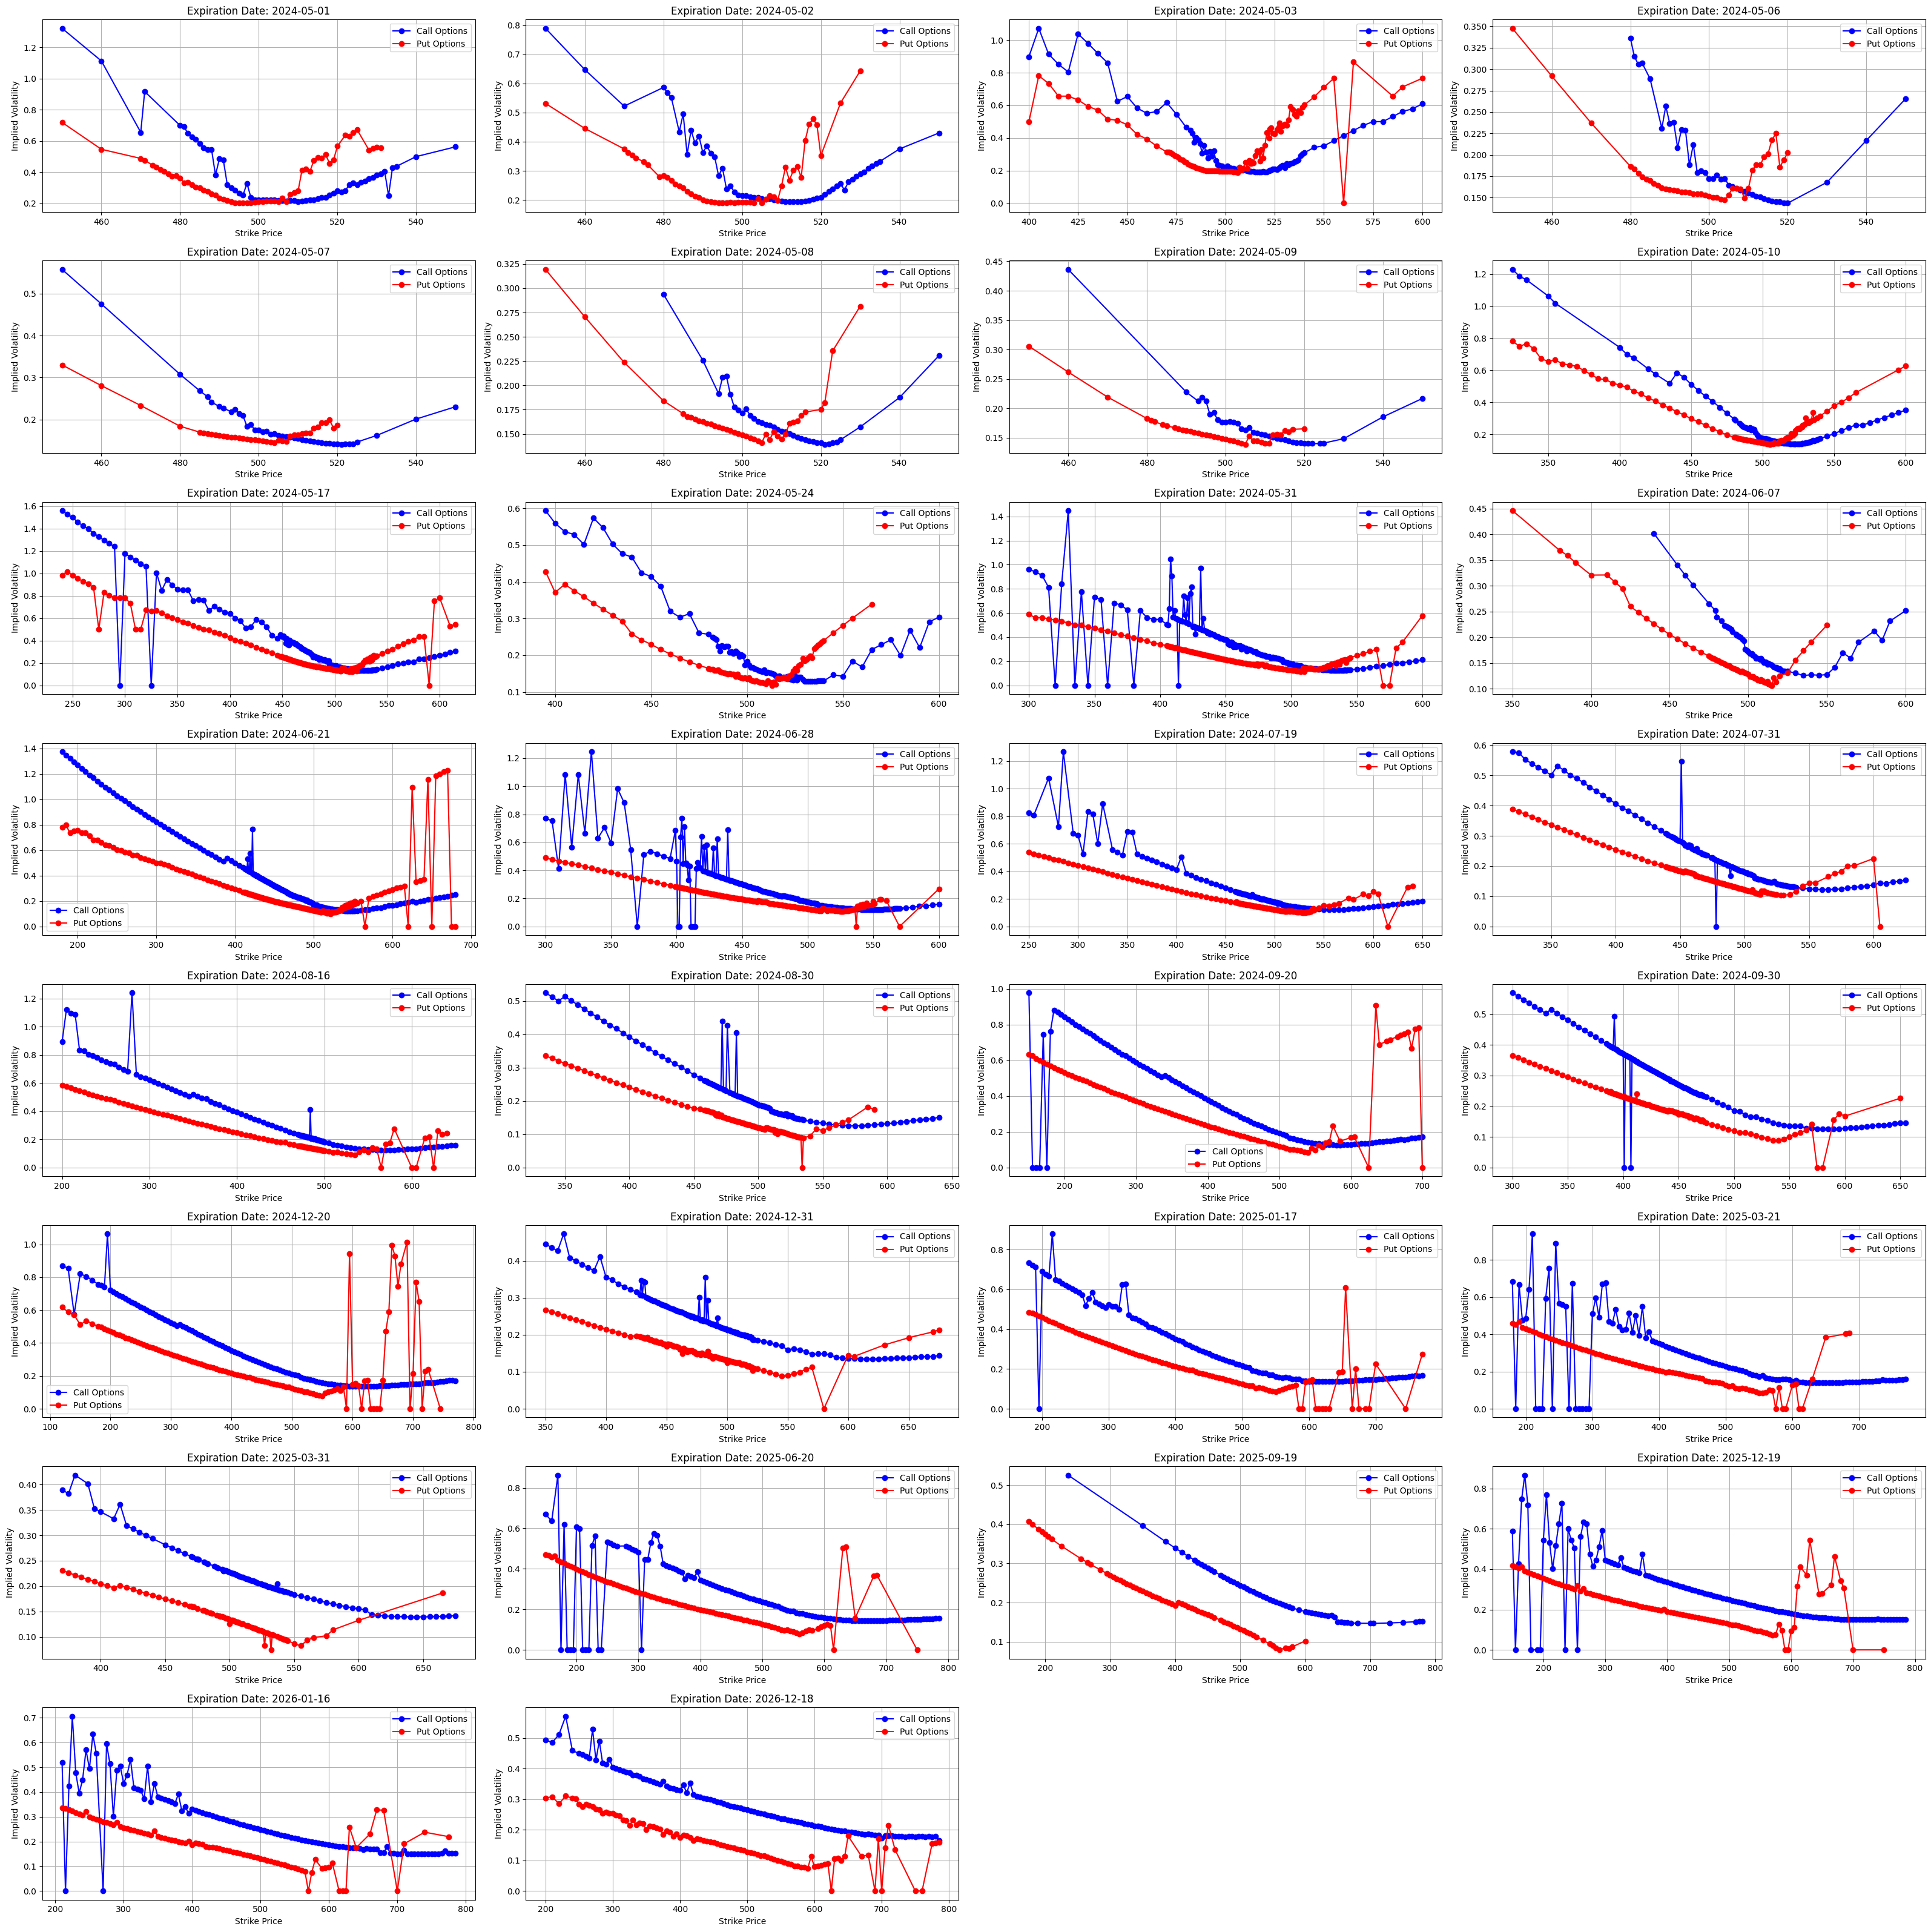

In [ ]:
plots = 4
rows = (len(expiration_dates) + plots - 1) // plots

fig, axes = plt.subplots(rows, plots, figsize=(8*plots,4*rows))
axes = axes.flatten()

for i, expiration_date in enumerate(expiration_dates):
    options_data = fetch_option_chain(symbol, expiration_date)

    call_options = options_data.calls
    put_options = options_data.puts

    ax = axes[i]

    ax.plot(call_options['strike'], call_options['impliedVolatility'], marker='o', color='blue', label='Call Options')
    ax.plot(put_options['strike'], put_options['impliedVolatility'], marker='o', color='red', label='Put Options')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Implied Volatility')
    ax.set_title(f'Expiration Date: {expiration_date}')
    ax.grid(True)
    ax.legend()

for i in range(len(expiration_dates), rows * plots):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Computing Realized Volatility**

In [ ]:
ticker = '^VIX'
start_date = '2024-01-01'
end_date = '2024-05-01'
vol = yf.download(ticker, start=start_date, end=end_date)
vol = vol['Adj Close']
vol_df = pd.DataFrame(vol)
vol_df.tail()

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2024-04-24,15.97
2024-04-25,15.37
2024-04-26,15.03
2024-04-29,14.67
2024-04-30,15.65


In [ ]:
realized_volatility = vol_df['Adj Close'].mean() / 100
realized_volatility

0.1434891562864005

**Calling SPY Option Chain**

In [ ]:
all_options_data = []

for expiration_date in expiration_dates:
    options_data = fetch_option_chain(symbol, expiration_date)

    call_options = options_data.calls
    put_options = options_data.puts

    calls_df = pd.DataFrame(call_options)
    puts_df = pd.DataFrame(put_options)

    all_options_data.append(calls_df)
    all_options_data.append(puts_df)

options_df = pd.concat(all_options_data, ignore_index=True)
print(options_df)

          contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0     SPY240501C00450000 2024-04-30 20:00:58+00:00   450.0      50.60   51.10   
1     SPY240501C00460000 2024-04-30 14:10:18+00:00   460.0      45.22   41.12   
2     SPY240501C00470000 2024-04-30 20:08:50+00:00   470.0      32.16   31.06   
3     SPY240501C00471000 2024-04-26 13:33:55+00:00   471.0      35.77   30.02   
4     SPY240501C00480000 2024-04-30 20:00:34+00:00   480.0      22.10   20.98   
...                  ...                       ...     ...        ...     ...   
6300  SPY261218P00750000 2024-02-06 15:42:10+00:00   750.0     255.00  233.58   
6301  SPY261218P00760000 2024-03-01 16:00:48+00:00   760.0     249.30  234.00   
6302  SPY261218P00775000 2024-04-04 18:10:04+00:00   775.0     254.46  270.50   
6303  SPY261218P00780000 2024-04-26 19:09:07+00:00   780.0     270.49  275.50   
6304  SPY261218P00785000 2024-04-03 13:36:19+00:00   785.0     266.70  280.50   

         ask    change  per

In [ ]:
options_df['date'] = options_df['contractSymbol'].str[3:9]
options_df['type'] = options_df['contractSymbol'].str[9]
columns_to_drop = ['contractSymbol','lastTradeDate', 'change', 'percentChange', 'bid', 'ask', 'openInterest', 'contractSize', 'currency']
options_df.drop(columns=columns_to_drop, inplace=True)
desired_column_order = ['date', 'strike', 'type', 'lastPrice', 'inTheMoney', 'volume', 'impliedVolatility']
options_df = options_df[desired_column_order]
options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility
0,240501,450.0,C,50.60,True,107.0,1.321292
1,240501,460.0,C,45.22,True,11.0,1.112309
2,240501,470.0,C,32.16,True,9.0,0.655277
3,240501,471.0,C,35.77,True,1.0,0.916505
4,240501,480.0,C,22.10,True,8.0,0.699222
...,...,...,...,...,...,...,...
6300,261218,750.0,P,255.00,True,507.0,0.000010
6301,261218,760.0,P,249.30,True,1.0,0.000010
6302,261218,775.0,P,254.46,True,1.0,0.155007
6303,261218,780.0,P,270.49,True,1.0,0.156777


In [ ]:
options_df['date'] = pd.to_datetime(options_df['date'], format='%y%m%d')
current_date = pd.to_datetime('2024-04-30')
options_df['T'] = (options_df['date'] - current_date).dt.days / 365
options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T
0,2024-05-01,450.0,C,50.60,True,107.0,1.321292,0.002740
1,2024-05-01,460.0,C,45.22,True,11.0,1.112309,0.002740
2,2024-05-01,470.0,C,32.16,True,9.0,0.655277,0.002740
3,2024-05-01,471.0,C,35.77,True,1.0,0.916505,0.002740
4,2024-05-01,480.0,C,22.10,True,8.0,0.699222,0.002740
...,...,...,...,...,...,...,...,...
6300,2026-12-18,750.0,P,255.00,True,507.0,0.000010,2.635616
6301,2026-12-18,760.0,P,249.30,True,1.0,0.000010,2.635616
6302,2026-12-18,775.0,P,254.46,True,1.0,0.155007,2.635616
6303,2026-12-18,780.0,P,270.49,True,1.0,0.156777,2.635616


**Defining the Black Scholes Model**

In [ ]:
spy = 501.98 #price as of April 30
r = 0.0403

options_df['d1'] = (np.log(spy / options_df['strike']) + (r + 0.5 * options_df['impliedVolatility'] ** 2) * options_df['T'] / 365) / (options_df['impliedVolatility'] * np.sqrt(options_df['T'] / 365))
options_df['d2'] = options_df['d1'] - options_df['impliedVolatility'] * np.sqrt(options_df['T'] / 365)

options_df['BS'] = 0
options_df.loc[options_df['type'] == 'C', 'BS'] = spy * norm.cdf(options_df['d1']) - options_df['strike'] * np.exp(-r * options_df['T'] / 365) * norm.cdf(options_df['d2'])
options_df.loc[options_df['type'] == 'P', 'BS'] = options_df['strike'] * np.exp(-r * options_df['T'] / 365) * norm.cdf(-options_df['d2']) - spy * norm.cdf(-options_df['d1'])

options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,d1,d2,BS
0,2024-05-01,450.0,C,50.60,True,107.0,1.321292,0.002740,30.198943,30.195323,51.980136
1,2024-05-01,460.0,C,45.22,True,11.0,1.112309,0.002740,28.659873,28.656825,41.980139
2,2024-05-01,470.0,C,32.16,True,9.0,0.655277,0.002740,36.668113,36.666317,31.980142
3,2024-05-01,471.0,C,35.77,True,1.0,0.916505,0.002740,25.370909,25.368398,30.980142
4,2024-05-01,480.0,C,22.10,True,8.0,0.699222,0.002740,23.373634,23.371719,21.980145
...,...,...,...,...,...,...,...,...,...,...,...
6300,2026-12-18,750.0,P,255.00,True,507.0,0.000010,2.635616,-472160.865479,-472160.865480,247.801781
6301,2026-12-18,760.0,P,249.30,True,1.0,0.000010,2.635616,-487747.944100,-487747.944101,257.798871
6302,2026-12-18,775.0,P,254.46,True,1.0,0.155007,2.635616,-32.943372,-32.956544,272.794507
6303,2026-12-18,780.0,P,270.49,True,1.0,0.156777,2.635616,-33.054012,-33.067335,277.793052


**Calculating Expected Move**

In [ ]:
expected_move_df = options_df.copy()
expected_move_df = expected_move_df[expected_move_df['strike'] == 502.0]
call_options = expected_move_df[expected_move_df['type'] == 'C']
call_options = call_options.reset_index(drop=True)
put_options = expected_move_df[expected_move_df['type'] == 'P']
put_options = put_options.reset_index(drop=True)

In [ ]:
call_options['expectedMove'] = 0.85 * (call_options['lastPrice'] + put_options['lastPrice'])
call_options = call_options[['date', 'expectedMove']]
call_options

,date,expectedMove
0,2024-05-01,3.7825
1,2024-05-02,4.9555
2,2024-05-03,6.2135
3,2024-05-06,6.9020
4,2024-05-07,7.3355
5,2024-05-08,7.7775
6,2024-05-09,8.3385
7,2024-05-10,8.7295
8,2024-05-17,10.9650
9,2024-05-24,12.8265


In [ ]:
options_df = pd.merge(options_df, call_options, on='date', how='left')
options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,d1,d2,BS,expectedMove
0,2024-05-01,450.0,C,50.60,True,107.0,1.321292,0.002740,30.198943,30.195323,51.980136,3.7825
1,2024-05-01,460.0,C,45.22,True,11.0,1.112309,0.002740,28.659873,28.656825,41.980139,3.7825
2,2024-05-01,470.0,C,32.16,True,9.0,0.655277,0.002740,36.668113,36.666317,31.980142,3.7825
3,2024-05-01,471.0,C,35.77,True,1.0,0.916505,0.002740,25.370909,25.368398,30.980142,3.7825
4,2024-05-01,480.0,C,22.10,True,8.0,0.699222,0.002740,23.373634,23.371719,21.980145,3.7825
...,...,...,...,...,...,...,...,...,...,...,...,...
6300,2026-12-18,750.0,P,255.00,True,507.0,0.000010,2.635616,-472160.865479,-472160.865480,247.801781,NaN
6301,2026-12-18,760.0,P,249.30,True,1.0,0.000010,2.635616,-487747.944100,-487747.944101,257.798871,NaN
6302,2026-12-18,775.0,P,254.46,True,1.0,0.155007,2.635616,-32.943372,-32.956544,272.794507,NaN
6303,2026-12-18,780.0,P,270.49,True,1.0,0.156777,2.635616,-33.054012,-33.067335,277.793052,NaN


**Generating Signals**

In [ ]:
options_df['signal'] = 0
options_df.loc[options_df['impliedVolatility'] > realized_volatility, 'signal'] = -1
options_df.loc[options_df['impliedVolatility'] <= realized_volatility, 'signal'] = 1
options_df.dropna(axis=0, inplace=True)
options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,d1,d2,BS,expectedMove,signal
0,2024-05-01,450.0,C,50.60,True,107.0,1.321292,0.002740,30.198943,30.195323,51.980136,3.7825,-1
1,2024-05-01,460.0,C,45.22,True,11.0,1.112309,0.002740,28.659873,28.656825,41.980139,3.7825,-1
2,2024-05-01,470.0,C,32.16,True,9.0,0.655277,0.002740,36.668113,36.666317,31.980142,3.7825,-1
3,2024-05-01,471.0,C,35.77,True,1.0,0.916505,0.002740,25.370909,25.368398,30.980142,3.7825,-1
4,2024-05-01,480.0,C,22.10,True,8.0,0.699222,0.002740,23.373634,23.371719,21.980145,3.7825,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.092523,0.917808,-17.698414,-17.703054,42.964775,55.7600,1
5298,2025-03-31,550.0,P,49.31,True,1.0,0.086252,0.917808,-21.097078,-21.101403,47.964268,55.7600,1
5301,2025-03-31,565.0,P,56.29,True,8.0,0.098550,0.917808,-23.908556,-23.913498,62.962748,55.7600,1
5303,2025-03-31,580.0,P,67.75,True,2.0,0.113717,0.917808,-25.314023,-25.319726,77.961228,55.7600,1


**Defining Inital Delta Neutral Portfolio**

In [ ]:
options_df['investment'] = 0
options_df['investment'] = np.where(
    (options_df['type'] == 'C') & (options_df['signal'] == 1),
    (options_df['lastPrice'] - spy) * 100,
    options_df['investment']
)
options_df['investment'] = np.where(
    (options_df['type'] == 'C') & (options_df['signal'] == -1),
    (-options_df['lastPrice'] + spy) * 100,
    options_df['investment']
)
options_df['investment'] = np.where(
    (options_df['type'] == 'P') & (options_df['signal'] == 1),
    (options_df['lastPrice'] + spy) * 100,
    options_df['investment']
)
options_df['investment'] = np.where(
    (options_df['type'] == 'P') & (options_df['signal'] == -1),
    (-options_df['lastPrice'] - spy) * 100,
    options_df['investment']
)
options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,d1,d2,BS,expectedMove,signal,investment
0,2024-05-01,450.0,C,50.60,True,107.0,1.321292,0.002740,30.198943,30.195323,51.980136,3.7825,-1,45138.0
1,2024-05-01,460.0,C,45.22,True,11.0,1.112309,0.002740,28.659873,28.656825,41.980139,3.7825,-1,45676.0
2,2024-05-01,470.0,C,32.16,True,9.0,0.655277,0.002740,36.668113,36.666317,31.980142,3.7825,-1,46982.0
3,2024-05-01,471.0,C,35.77,True,1.0,0.916505,0.002740,25.370909,25.368398,30.980142,3.7825,-1,46621.0
4,2024-05-01,480.0,C,22.10,True,8.0,0.699222,0.002740,23.373634,23.371719,21.980145,3.7825,-1,47988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.092523,0.917808,-17.698414,-17.703054,42.964775,55.7600,1,54428.0
5298,2025-03-31,550.0,P,49.31,True,1.0,0.086252,0.917808,-21.097078,-21.101403,47.964268,55.7600,1,55129.0
5301,2025-03-31,565.0,P,56.29,True,8.0,0.098550,0.917808,-23.908556,-23.913498,62.962748,55.7600,1,55827.0
5303,2025-03-31,580.0,P,67.75,True,2.0,0.113717,0.917808,-25.314023,-25.319726,77.961228,55.7600,1,56973.0


**Calculating Upper and Lower Black Scholes Prices**

In [ ]:
options_df['dd1'] = (np.log((spy-options_df['expectedMove']) / options_df['strike']) + (r + 0.5 * options_df['impliedVolatility'] ** 2) * options_df['T'] / 365) / (options_df['impliedVolatility'] * np.sqrt(options_df['T'] / 365))
options_df['dd2'] = options_df['dd1'] - options_df['impliedVolatility'] * np.sqrt(options_df['T'] / 365)

options_df['dBS'] = 0
options_df.loc[options_df['type'] == 'C', 'dBS'] = (spy-options_df['expectedMove']) * norm.cdf(options_df['dd1']) - options_df['strike'] * np.exp(-r * options_df['T'] / 365) * norm.cdf(options_df['dd2'])
options_df.loc[options_df['type'] == 'P', 'dBS'] = options_df['strike'] * np.exp(-r * options_df['T'] / 365) * norm.cdf(-options_df['dd2']) - (spy-options_df['expectedMove']) * norm.cdf(-options_df['dd1'])

options_df['ud1'] = (np.log((spy+options_df['expectedMove']) / options_df['strike']) + (r + 0.5 * options_df['impliedVolatility'] ** 2) * options_df['T'] / 365) / (options_df['impliedVolatility'] * np.sqrt(options_df['T'] / 365))
options_df['ud2'] = options_df['ud1'] - options_df['impliedVolatility'] * np.sqrt(options_df['T'] / 365)

options_df['uBS'] = 0
options_df.loc[options_df['type'] == 'C', 'uBS'] = (spy+options_df['expectedMove']) * norm.cdf(options_df['ud1']) - options_df['strike'] * np.exp(-r * options_df['T'] / 365) * norm.cdf(options_df['ud2'])
options_df.loc[options_df['type'] == 'P', 'uBS'] = options_df['strike'] * np.exp(-r * options_df['T'] / 365) * norm.cdf(-options_df['ud2']) - (spy+options_df['expectedMove']) * norm.cdf(-options_df['ud1'])

options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,d1,d2,BS,expectedMove,signal,investment,dd1,dd2,dBS,ud1,ud2,uBS
0,2024-05-01,450.0,C,50.60,True,107.0,1.321292,0.002740,30.198943,30.195323,51.980136,3.7825,-1,45138.0,28.109513,28.105893,48.197636,32.272688,32.269068,5.576264e+01
1,2024-05-01,460.0,C,45.22,True,11.0,1.112309,0.002740,28.659873,28.656825,41.980139,3.7825,-1,45676.0,26.177876,26.174828,38.197639,31.123238,31.120190,4.576264e+01
2,2024-05-01,470.0,C,32.16,True,9.0,0.655277,0.002740,36.668113,36.666317,31.980142,3.7825,-1,46982.0,32.455011,32.453216,28.197642,40.849587,40.847791,3.576264e+01
3,2024-05-01,471.0,C,35.77,True,1.0,0.916505,0.002740,25.370909,25.368398,30.980142,3.7825,-1,46621.0,22.358652,22.356141,27.197642,28.360553,28.358042,3.476264e+01
4,2024-05-01,480.0,C,22.10,True,8.0,0.699222,0.002740,23.373634,23.371719,21.980145,3.7825,-1,47988.0,19.425319,19.423403,18.197645,27.292310,27.290395,2.576265e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.092523,0.917808,-17.698414,-17.703054,42.964775,55.7600,1,54428.0,-43.077408,-43.082048,98.724775,5.004580,4.999940,1.350981e-07
5298,2025-03-31,550.0,P,49.31,True,1.0,0.086252,0.917808,-21.097078,-21.101403,47.964268,55.7600,1,55129.0,-48.321358,-48.325683,103.724268,3.256633,3.252308,3.620775e-04
5301,2025-03-31,565.0,P,56.29,True,8.0,0.098550,0.917808,-23.908556,-23.913498,62.962748,55.7600,1,55827.0,-47.735416,-47.740358,118.722748,-2.594038,-2.598979,7.206854e+00
5303,2025-03-31,580.0,P,67.75,True,2.0,0.113717,0.917808,-25.314023,-25.319726,77.961228,55.7600,1,56973.0,-45.962969,-45.968671,133.721228,-6.842335,-6.848037,2.220123e+01


In [ ]:
columns_to_drop = ['d1','d2', 'dd1', 'dd2', 'ud1', 'ud2']
options_df.drop(columns=columns_to_drop, inplace=True)
desired_column_order = ['date', 'strike', 'type', 'lastPrice', 'inTheMoney', 'volume', 'impliedVolatility', 'T', 'signal', 'investment', 'expectedMove', 'BS', 'dBS', 'uBS']
options_df = options_df[desired_column_order]
options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,expectedMove,BS,dBS,uBS
0,2024-05-01,450.0,C,50.60,True,107.0,1.321292,0.002740,-1,45138.0,3.7825,51.980136,48.197636,5.576264e+01
1,2024-05-01,460.0,C,45.22,True,11.0,1.112309,0.002740,-1,45676.0,3.7825,41.980139,38.197639,4.576264e+01
2,2024-05-01,470.0,C,32.16,True,9.0,0.655277,0.002740,-1,46982.0,3.7825,31.980142,28.197642,3.576264e+01
3,2024-05-01,471.0,C,35.77,True,1.0,0.916505,0.002740,-1,46621.0,3.7825,30.980142,27.197642,3.476264e+01
4,2024-05-01,480.0,C,22.10,True,8.0,0.699222,0.002740,-1,47988.0,3.7825,21.980145,18.197645,2.576265e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.092523,0.917808,1,54428.0,55.7600,42.964775,98.724775,1.350981e-07
5298,2025-03-31,550.0,P,49.31,True,1.0,0.086252,0.917808,1,55129.0,55.7600,47.964268,103.724268,3.620775e-04
5301,2025-03-31,565.0,P,56.29,True,8.0,0.098550,0.917808,1,55827.0,55.7600,62.962748,118.722748,7.206854e+00
5303,2025-03-31,580.0,P,67.75,True,2.0,0.113717,0.917808,1,56973.0,55.7600,77.961228,133.721228,2.220123e+01


In [ ]:
columns_to_round = ['impliedVolatility', 'T', 'expectedMove', 'BS', 'dBS', 'uBS']
options_df.loc[:, columns_to_round] = options_df[columns_to_round].apply(lambda x: x.round(2))
options_df

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,expectedMove,BS,dBS,uBS
0,2024-05-01,450.0,C,50.60,True,107.0,1.32,0.00,-1,45138.0,3.78,51.98,48.20,55.76
1,2024-05-01,460.0,C,45.22,True,11.0,1.11,0.00,-1,45676.0,3.78,41.98,38.20,45.76
2,2024-05-01,470.0,C,32.16,True,9.0,0.66,0.00,-1,46982.0,3.78,31.98,28.20,35.76
3,2024-05-01,471.0,C,35.77,True,1.0,0.92,0.00,-1,46621.0,3.78,30.98,27.20,34.76
4,2024-05-01,480.0,C,22.10,True,8.0,0.70,0.00,-1,47988.0,3.78,21.98,18.20,25.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.09,0.92,1,54428.0,55.76,42.96,98.72,0.00
5298,2025-03-31,550.0,P,49.31,True,1.0,0.09,0.92,1,55129.0,55.76,47.96,103.72,0.00
5301,2025-03-31,565.0,P,56.29,True,8.0,0.10,0.92,1,55827.0,55.76,62.96,118.72,7.21
5303,2025-03-31,580.0,P,67.75,True,2.0,0.11,0.92,1,56973.0,55.76,77.96,133.72,22.20


**Calculating Final Portfolio Values for the 3 Scenarios**

In [ ]:
options_df_bearish = options_df.copy()
options_df_bearish['bearish'] = 0
options_df_bearish['bearish'] = np.where(
    (options_df_bearish['type'] == 'C') & (options_df_bearish['signal'] == 1),
    (options_df_bearish['dBS'] - (spy - options_df_bearish['expectedMove'])) * 100,
    options_df_bearish['bearish']
)
options_df_bearish['bearish'] = np.where(
    (options_df_bearish['type'] == 'C') & (options_df_bearish['signal'] == -1),
    (-options_df_bearish['dBS'] + (spy - options_df_bearish['expectedMove'])) * 100,
    options_df_bearish['bearish']
)
options_df_bearish['bearish'] = np.where(
    (options_df_bearish['type'] == 'P') & (options_df_bearish['signal'] == 1),
    (options_df_bearish['dBS'] + (spy - options_df_bearish['expectedMove'])) * 100,
    options_df_bearish['bearish']
)
options_df_bearish['bearish'] = np.where(
    (options_df_bearish['type'] == 'P') & (options_df_bearish['signal'] == -1),
    (-options_df_bearish['dBS'] - (spy - options_df_bearish['expectedMove'])) * 100,
    options_df_bearish['bearish']
)
options_df_bearish

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,expectedMove,BS,dBS,uBS,bearish
0,2024-05-01,450.0,C,50.60,True,107.0,1.32,0.00,-1,45138.0,3.78,51.98,48.20,55.76,45000.0
1,2024-05-01,460.0,C,45.22,True,11.0,1.11,0.00,-1,45676.0,3.78,41.98,38.20,45.76,46000.0
2,2024-05-01,470.0,C,32.16,True,9.0,0.66,0.00,-1,46982.0,3.78,31.98,28.20,35.76,47000.0
3,2024-05-01,471.0,C,35.77,True,1.0,0.92,0.00,-1,46621.0,3.78,30.98,27.20,34.76,47100.0
4,2024-05-01,480.0,C,22.10,True,8.0,0.70,0.00,-1,47988.0,3.78,21.98,18.20,25.76,48000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.09,0.92,1,54428.0,55.76,42.96,98.72,0.00,54494.0
5298,2025-03-31,550.0,P,49.31,True,1.0,0.09,0.92,1,55129.0,55.76,47.96,103.72,0.00,54994.0
5301,2025-03-31,565.0,P,56.29,True,8.0,0.10,0.92,1,55827.0,55.76,62.96,118.72,7.21,56494.0
5303,2025-03-31,580.0,P,67.75,True,2.0,0.11,0.92,1,56973.0,55.76,77.96,133.72,22.20,57994.0


In [ ]:
options_df_bullish = options_df_bearish.copy()
options_df_bullish['bullish'] = 0
options_df_bullish['bullish'] = np.where(
    (options_df_bullish['type'] == 'C') & (options_df_bullish['signal'] == 1),
    (options_df_bullish['uBS'] - (spy + options_df_bullish['expectedMove'])) * 100,
    options_df_bullish['bullish']
)
options_df_bullish['bullish'] = np.where(
    (options_df_bullish['type'] == 'C') & (options_df_bullish['signal'] == -1),
    (-options_df_bullish['uBS'] + (spy + options_df_bullish['expectedMove'])) * 100,
    options_df_bullish['bullish']
)
options_df_bullish['bullish'] = np.where(
    (options_df_bullish['type'] == 'P') & (options_df_bullish['signal'] == 1),
    (options_df_bullish['uBS'] + (spy + options_df_bullish['expectedMove'])) * 100,
    options_df_bullish['bullish']
)
options_df_bullish['bullish'] = np.where(
    (options_df_bullish['type'] == 'P') & (options_df_bullish['signal'] == -1),
    (-options_df_bullish['uBS'] - (spy + options_df_bullish['expectedMove'])) * 100,
    options_df_bullish['bullish']
)
options_df_bullish

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,expectedMove,BS,dBS,uBS,bearish,bullish
0,2024-05-01,450.0,C,50.60,True,107.0,1.32,0.00,-1,45138.0,3.78,51.98,48.20,55.76,45000.0,45000.0
1,2024-05-01,460.0,C,45.22,True,11.0,1.11,0.00,-1,45676.0,3.78,41.98,38.20,45.76,46000.0,46000.0
2,2024-05-01,470.0,C,32.16,True,9.0,0.66,0.00,-1,46982.0,3.78,31.98,28.20,35.76,47000.0,47000.0
3,2024-05-01,471.0,C,35.77,True,1.0,0.92,0.00,-1,46621.0,3.78,30.98,27.20,34.76,47100.0,47100.0
4,2024-05-01,480.0,C,22.10,True,8.0,0.70,0.00,-1,47988.0,3.78,21.98,18.20,25.76,48000.0,48000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.09,0.92,1,54428.0,55.76,42.96,98.72,0.00,54494.0,55774.0
5298,2025-03-31,550.0,P,49.31,True,1.0,0.09,0.92,1,55129.0,55.76,47.96,103.72,0.00,54994.0,55774.0
5301,2025-03-31,565.0,P,56.29,True,8.0,0.10,0.92,1,55827.0,55.76,62.96,118.72,7.21,56494.0,56495.0
5303,2025-03-31,580.0,P,67.75,True,2.0,0.11,0.92,1,56973.0,55.76,77.96,133.72,22.20,57994.0,57994.0


In [ ]:
options_df_choppy = options_df_bullish.copy()
options_df_choppy['choppy'] = 0
options_df_choppy['choppy'] = np.where(
    (options_df_choppy['type'] == 'C') & (options_df_choppy['signal'] == 1),
    (options_df_choppy['BS'] - (spy + 0)) * 100,
    options_df_choppy['choppy']
)
options_df_choppy['choppy'] = np.where(
    (options_df_choppy['type'] == 'C') & (options_df_choppy['signal'] == -1),
    (-options_df_choppy['BS'] + (spy + 0)) * 100,
    options_df_choppy['choppy']
)
options_df_choppy['choppy'] = np.where(
    (options_df_choppy['type'] == 'P') & (options_df_choppy['signal'] == 1),
    (options_df_choppy['BS'] + (spy + 0)) * 100,
    options_df_choppy['choppy']
)
options_df_choppy['choppy'] = np.where(
    (options_df_choppy['type'] == 'P') & (options_df_choppy['signal'] == -1),
    (-options_df_choppy['BS'] - (spy + 0)) * 100,
    options_df_choppy['choppy']
)
options_df_choppy

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,expectedMove,BS,dBS,uBS,bearish,bullish,choppy
0,2024-05-01,450.0,C,50.60,True,107.0,1.32,0.00,-1,45138.0,3.78,51.98,48.20,55.76,45000.0,45000.0,45000.0
1,2024-05-01,460.0,C,45.22,True,11.0,1.11,0.00,-1,45676.0,3.78,41.98,38.20,45.76,46000.0,46000.0,46000.0
2,2024-05-01,470.0,C,32.16,True,9.0,0.66,0.00,-1,46982.0,3.78,31.98,28.20,35.76,47000.0,47000.0,47000.0
3,2024-05-01,471.0,C,35.77,True,1.0,0.92,0.00,-1,46621.0,3.78,30.98,27.20,34.76,47100.0,47100.0,47100.0
4,2024-05-01,480.0,C,22.10,True,8.0,0.70,0.00,-1,47988.0,3.78,21.98,18.20,25.76,48000.0,48000.0,48000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.09,0.92,1,54428.0,55.76,42.96,98.72,0.00,54494.0,55774.0,54494.0
5298,2025-03-31,550.0,P,49.31,True,1.0,0.09,0.92,1,55129.0,55.76,47.96,103.72,0.00,54994.0,55774.0,54994.0
5301,2025-03-31,565.0,P,56.29,True,8.0,0.10,0.92,1,55827.0,55.76,62.96,118.72,7.21,56494.0,56495.0,56494.0
5303,2025-03-31,580.0,P,67.75,True,2.0,0.11,0.92,1,56973.0,55.76,77.96,133.72,22.20,57994.0,57994.0,57994.0


**Calculating Final PnL**

In [ ]:
options_final = options_df_choppy.copy()
options_final['bearishPnL'] = options_final['bearish'] - options_final['investment']
options_final['bullishPnL'] = options_final['bullish'] - options_final['investment']
options_final['choppyPnL'] = options_final['choppy'] - options_final['investment']
options_final['PnL'] = (options_final['bearishPnL'] + options_final['bullishPnL'] + options_final['choppyPnL']) / 3

options_final['bearish'] = options_final['bearish'].round(2)
options_final['bullish'] = options_final['bullish'].round(2)
options_final['choppy'] = options_final['choppy'].round(2)
options_final['bearishPnL'] = options_final['bearishPnL'].round(2)
options_final['bullishPnL'] = options_final['bullishPnL'].round(2)
options_final['choppyPnL'] = options_final['choppyPnL'].round(2)
options_final['PnL'] = options_final['PnL'].round(2)

options_final

,date,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,...,BS,dBS,uBS,bearish,bullish,choppy,bearishPnL,bullishPnL,choppyPnL,PnL
0,2024-05-01,450.0,C,50.60,True,107.0,1.32,0.00,-1,45138.0,...,51.98,48.20,55.76,45000.0,45000.0,45000.0,-138.0,-138.0,-138.0,-138.00
1,2024-05-01,460.0,C,45.22,True,11.0,1.11,0.00,-1,45676.0,...,41.98,38.20,45.76,46000.0,46000.0,46000.0,324.0,324.0,324.0,324.00
2,2024-05-01,470.0,C,32.16,True,9.0,0.66,0.00,-1,46982.0,...,31.98,28.20,35.76,47000.0,47000.0,47000.0,18.0,18.0,18.0,18.00
3,2024-05-01,471.0,C,35.77,True,1.0,0.92,0.00,-1,46621.0,...,30.98,27.20,34.76,47100.0,47100.0,47100.0,479.0,479.0,479.0,479.00
4,2024-05-01,480.0,C,22.10,True,8.0,0.70,0.00,-1,47988.0,...,21.98,18.20,25.76,48000.0,48000.0,48000.0,12.0,12.0,12.0,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2025-03-31,545.0,P,42.30,True,135.0,0.09,0.92,1,54428.0,...,42.96,98.72,0.00,54494.0,55774.0,54494.0,66.0,1346.0,66.0,492.67
5298,2025-03-31,550.0,P,49.31,True,1.0,0.09,0.92,1,55129.0,...,47.96,103.72,0.00,54994.0,55774.0,54994.0,-135.0,645.0,-135.0,125.00
5301,2025-03-31,565.0,P,56.29,True,8.0,0.10,0.92,1,55827.0,...,62.96,118.72,7.21,56494.0,56495.0,56494.0,667.0,668.0,667.0,667.33
5303,2025-03-31,580.0,P,67.75,True,2.0,0.11,0.92,1,56973.0,...,77.96,133.72,22.20,57994.0,57994.0,57994.0,1021.0,1021.0,1021.0,1021.00


**Creating an Options Filter**

In [ ]:
options_final = options_final[options_final['lastPrice']>=0.25]
options_final = options_final[options_final['volume']>=2500]
options_final = options_final[options_final['strike']>=440]
options_final = options_final[options_final['strike']<=560]
options_final.set_index('date', inplace=True)
options_final

,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,expectedMove,BS,dBS,uBS,bearish,bullish,choppy,bearishPnL,bullishPnL,choppyPnL,PnL
date,,,,,,,,,,,,,,,,,,,,
2024-05-01,502.0,C,2.25,False,5356.0,0.22,0.00,-1,49973.0,3.78,0.11,0.00,3.76,49820.0,50200.0,50187.0,-153.0,227.0,214.0,96.00
2024-05-01,503.0,C,1.82,False,12558.0,0.22,0.00,-1,50016.0,3.78,0.00,0.00,2.76,49820.0,50300.0,50198.0,-196.0,284.0,182.0,90.00
2024-05-01,504.0,C,1.40,False,20509.0,0.22,0.00,-1,50058.0,3.78,0.00,0.00,1.76,49820.0,50400.0,50198.0,-238.0,342.0,140.0,81.33
2024-05-01,505.0,C,1.07,False,56350.0,0.22,0.00,-1,50091.0,3.78,0.00,0.00,0.76,49820.0,50500.0,50198.0,-271.0,409.0,107.0,81.67
2024-05-01,506.0,C,0.79,False,63978.0,0.22,0.00,-1,50119.0,3.78,0.00,0.00,0.04,49820.0,50572.0,50198.0,-299.0,453.0,79.0,77.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-19,500.0,C,16.65,True,3096.0,0.18,0.22,-1,48533.0,22.59,2.20,0.00,24.59,47939.0,49998.0,49978.0,-594.0,1465.0,1445.0,772.00
2024-07-19,490.0,P,7.37,False,2534.0,0.14,0.22,1,50935.0,22.59,0.00,10.60,0.00,48999.0,52457.0,50198.0,-1936.0,1522.0,-737.0,-383.67
2024-07-31,532.0,C,3.75,False,3432.0,0.13,0.25,1,-49823.0,23.12,0.00,0.00,0.00,-47886.0,-52510.0,-50198.0,1937.0,-2687.0,-375.0,-375.00


**Conducting Analysis**

In [ ]:
analysis = options_final.copy()
analysis

,strike,type,lastPrice,inTheMoney,volume,impliedVolatility,T,signal,investment,expectedMove,BS,dBS,uBS,bearish,bullish,choppy,bearishPnL,bullishPnL,choppyPnL,PnL
date,,,,,,,,,,,,,,,,,,,,
2024-05-01,502.0,C,2.25,False,5356.0,0.22,0.00,-1,49973.0,3.78,0.11,0.00,3.76,49820.0,50200.0,50187.0,-153.0,227.0,214.0,96.00
2024-05-01,503.0,C,1.82,False,12558.0,0.22,0.00,-1,50016.0,3.78,0.00,0.00,2.76,49820.0,50300.0,50198.0,-196.0,284.0,182.0,90.00
2024-05-01,504.0,C,1.40,False,20509.0,0.22,0.00,-1,50058.0,3.78,0.00,0.00,1.76,49820.0,50400.0,50198.0,-238.0,342.0,140.0,81.33
2024-05-01,505.0,C,1.07,False,56350.0,0.22,0.00,-1,50091.0,3.78,0.00,0.00,0.76,49820.0,50500.0,50198.0,-271.0,409.0,107.0,81.67
2024-05-01,506.0,C,0.79,False,63978.0,0.22,0.00,-1,50119.0,3.78,0.00,0.00,0.04,49820.0,50572.0,50198.0,-299.0,453.0,79.0,77.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-19,500.0,C,16.65,True,3096.0,0.18,0.22,-1,48533.0,22.59,2.20,0.00,24.59,47939.0,49998.0,49978.0,-594.0,1465.0,1445.0,772.00
2024-07-19,490.0,P,7.37,False,2534.0,0.14,0.22,1,50935.0,22.59,0.00,10.60,0.00,48999.0,52457.0,50198.0,-1936.0,1522.0,-737.0,-383.67
2024-07-31,532.0,C,3.75,False,3432.0,0.13,0.25,1,-49823.0,23.12,0.00,0.00,0.00,-47886.0,-52510.0,-50198.0,1937.0,-2687.0,-375.0,-375.00


In [ ]:
win_rate_bullish = (analysis['bullishPnL'] > 0).sum() / len(analysis)
lc_win_rate_bullish = ((analysis['bullishPnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == 1)).sum() / len(analysis)
lp_win_rate_bullish = ((analysis['bullishPnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == 1)).sum() / len(analysis)
sc_win_rate_bullish = ((analysis['bullishPnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == -1)).sum() / len(analysis)
sp_win_rate_bullish = ((analysis['bullishPnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == -1)).sum() / len(analysis)
total_profit_bullish = analysis['bullishPnL'].sum()
avg_profit_bullish = analysis['bullishPnL'].mean()
max_profit_bullish = analysis['bullishPnL'].max()
max_loss_bullish = analysis['bullishPnL'].min()

In [ ]:
win_rate_bearish = (analysis['bearishPnL'] > 0).sum() / len(analysis)
lc_win_rate_bearish = ((analysis['bearishPnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == 1)).sum() / len(analysis)
lp_win_rate_bearish = ((analysis['bearishPnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == 1)).sum() / len(analysis)
sc_win_rate_bearish = ((analysis['bearishPnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == -1)).sum() / len(analysis)
sp_win_rate_bearish = ((analysis['bearishPnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == -1)).sum() / len(analysis)
total_profit_bearish = analysis['bearishPnL'].sum()
avg_profit_bearish = analysis['bearishPnL'].mean()
max_profit_bearish = analysis['bearishPnL'].max()
max_loss_bearish = analysis['bearishPnL'].min()

In [ ]:
win_rate_choppy = (analysis['choppyPnL'] > 0).sum() / len(analysis)
lc_win_rate_choppy = ((analysis['choppyPnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == 1)).sum() / len(analysis)
lp_win_rate_choppy = ((analysis['choppyPnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == 1)).sum() / len(analysis)
sc_win_rate_choppy = ((analysis['choppyPnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == -1)).sum() / len(analysis)
sp_win_rate_choppy = ((analysis['choppyPnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == -1)).sum() / len(analysis)
total_profit_choppy = analysis['choppyPnL'].sum()
avg_profit_choppy = analysis['choppyPnL'].mean()
max_profit_choppy = analysis['choppyPnL'].max()
max_loss_choppy = analysis['choppyPnL'].min()

In [ ]:
win_rate = (analysis['PnL'] > 0).sum() / len(analysis)
lc_win_rate = ((analysis['PnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == 1)).sum() / len(analysis)
lp_win_rate = ((analysis['PnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == 1)).sum() / len(analysis)
sc_win_rate = ((analysis['PnL'] > 0) & (analysis['type'] == 'C') & (analysis['signal'] == -1)).sum() / len(analysis)
sp_win_rate = ((analysis['PnL'] > 0) & (analysis['type'] == 'P') & (analysis['signal'] == -1)).sum() / len(analysis)
total_profit = analysis['PnL'].sum()
avg_profit = analysis['PnL'].mean()
max_profit = analysis['PnL'].max()
max_loss = analysis['PnL'].min()

**Tabulating Performance Metrics**

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Performance Metrics", "Bullish", "Bearish", "Choppy", "Average"]
separator_line = ["-" * len(col) for col in table.field_names]

table.add_row(["Total Profit", round(total_profit_bullish,2), round(total_profit_bearish,2), round(total_profit_choppy,2), round(total_profit,2)])
table.add_row(separator_line)
table.add_row(["Average Profit", round(avg_profit_bullish,2), round(avg_profit_bearish,2), round(avg_profit_choppy,2), round(avg_profit,2)])
table.add_row(separator_line)
table.add_row(["Max Profit", round(max_profit_bullish,2), round(max_profit_bearish,2), round(max_profit_choppy,2), round(max_profit,2)])
table.add_row(separator_line)
table.add_row(["Max Loss", round(max_loss_bullish,2), round(max_loss_bearish,2), round(max_loss_choppy,2), round(max_loss,2)])
table.add_row(separator_line)
table.add_row(["Win Rate", round(win_rate_bullish * 100,2), round(win_rate_bearish * 100,2), round(win_rate_choppy * 100,2), round(win_rate * 100,2)])
table.add_row(separator_line)
table.add_row(["Long Call Win Rate", round(lc_win_rate_bullish * 100,2), round(lc_win_rate_bearish * 100,2), round(lc_win_rate_choppy * 100,2), round(lc_win_rate * 100,2)])
table.add_row(separator_line)
table.add_row(["Short Call Win Rate", round(sc_win_rate_bullish * 100,2), round(sc_win_rate_bearish * 100,2), round(sc_win_rate_choppy * 100,2), round(sc_win_rate * 100,2)])
table.add_row(separator_line)
table.add_row(["Long Put Win Rate", round(lp_win_rate_bullish * 100,2), round(lp_win_rate_bearish * 100,2), round(lp_win_rate_choppy * 100,2), round(lp_win_rate * 100,2)])
table.add_row(separator_line)
table.add_row(["Short Put Win Rate", round(sp_win_rate_bullish * 100,2), round(sp_win_rate_bearish * 100,2), round(sp_win_rate_choppy * 100,2), round(sp_win_rate * 100,2)])
table.add_row(separator_line)

print(table)

+---------------------+---------+---------+---------+----------+
| Performance Metrics | Bullish | Bearish |  Choppy | Average  |
+---------------------+---------+---------+---------+----------+
|     Total Profit    |  2134.0 | 25436.0 | 17797.0 | 15122.35 |
| ------------------- | ------- | ------- |  ------ | -------  |
|    Average Profit   |  12.06  |  143.71 |  100.55 |  85.44   |
| ------------------- | ------- | ------- |  ------ | -------  |
|      Max Profit     |  1522.0 |  3555.0 |  1445.0 |  772.0   |
| ------------------- | ------- | ------- |  ------ | -------  |
|       Max Loss      | -2728.0 | -1936.0 |  -852.0 | -383.67  |
| ------------------- | ------- | ------- |  ------ | -------  |
|       Win Rate      |  53.67  |  58.19  |  87.57  |  87.57   |
| ------------------- | ------- | ------- |  ------ | -------  |
|  Long Call Win Rate |   0.0   |   2.26  |   0.0   |   0.0    |
| ------------------- | ------- | ------- |  ------ | -------  |
| Short Call Win Rate |  

**Creating Plots**

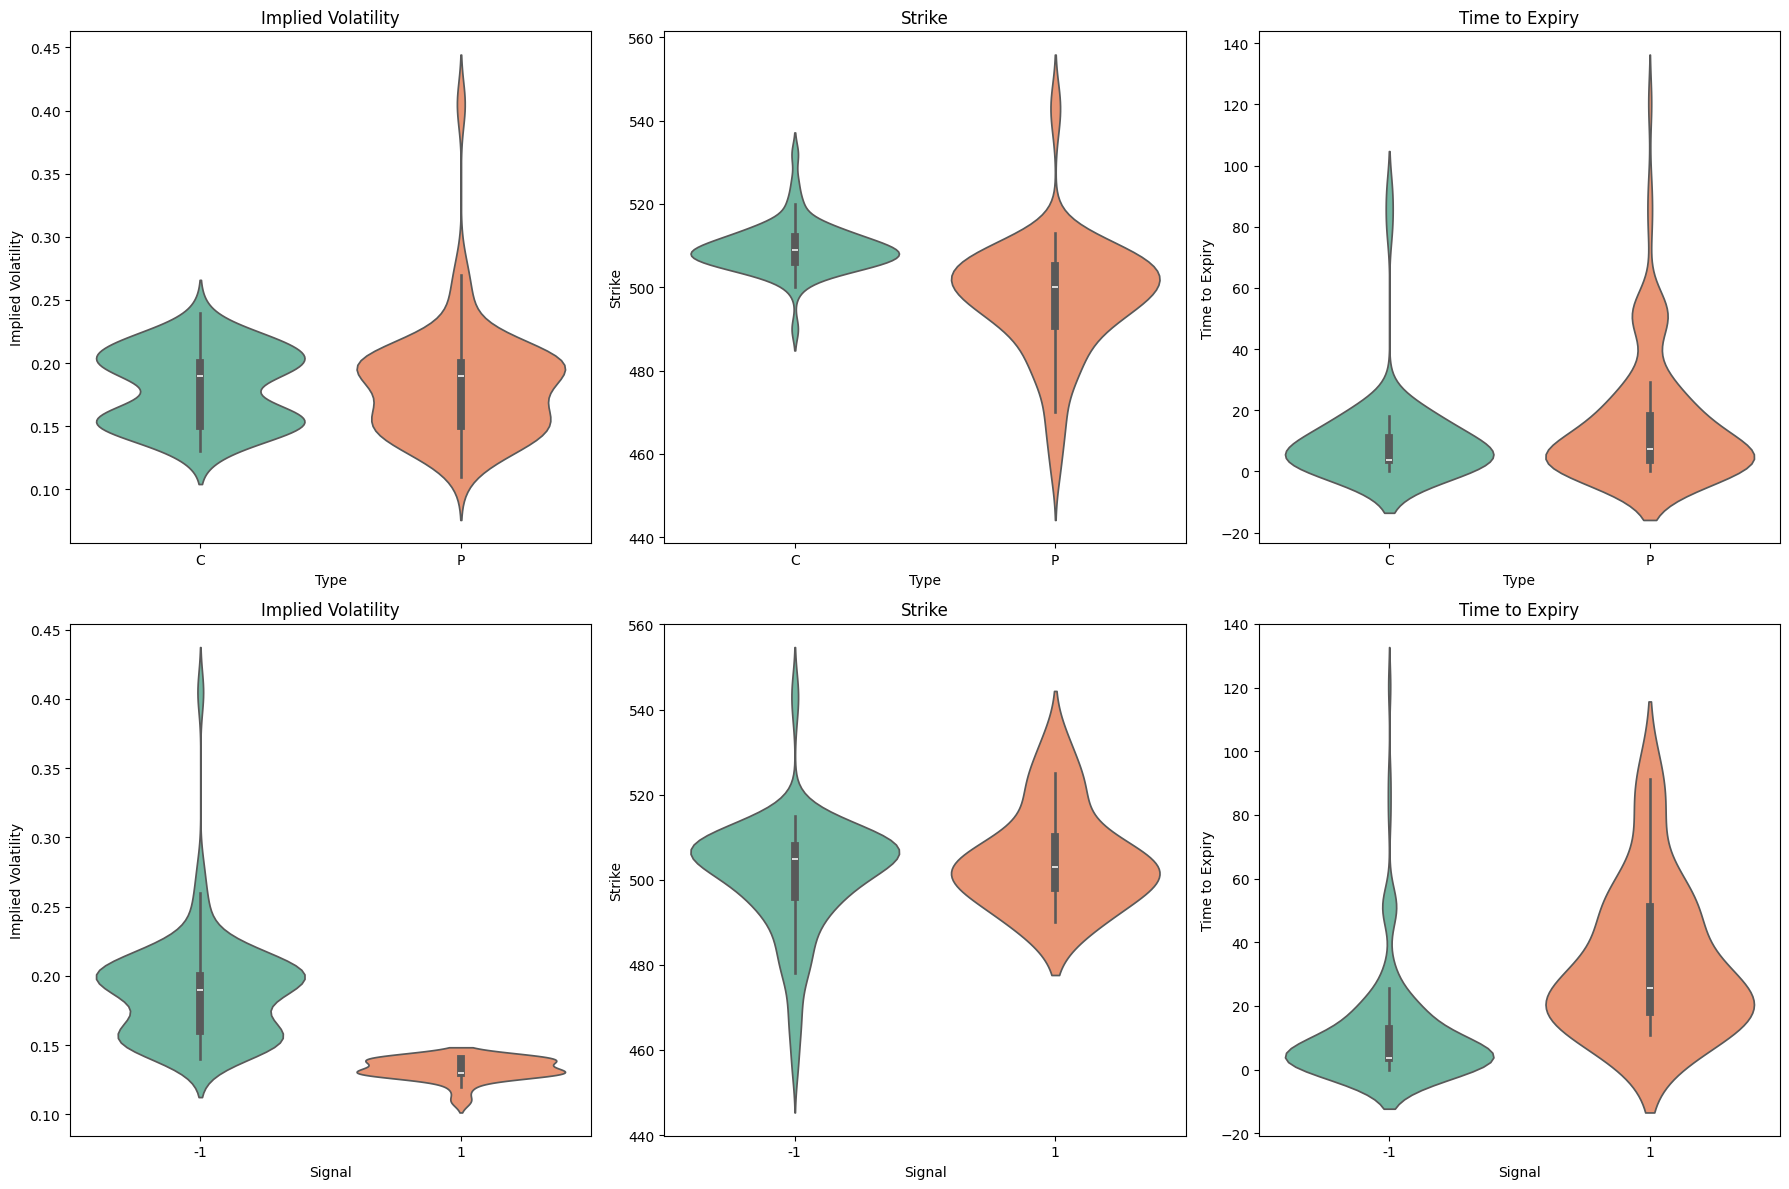

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.violinplot(data=analysis, x='type', y='impliedVolatility', palette='Set2', hue='type', legend=False, ax=axes[0,0])
axes[0,0].set_title('Implied Volatility')
axes[0,0].set_xlabel('Type')
axes[0,0].set_ylabel('Implied Volatility')

sns.violinplot(data=analysis, x='type', y='strike', palette='Set2', hue='type', legend=False, ax=axes[0,1])
axes[0,1].set_title('Strike')
axes[0,1].set_xlabel('Type')
axes[0,1].set_ylabel('Strike')

sns.violinplot(data=analysis, x='type', y=analysis['T']*365, palette='Set2', hue='type', legend=False, ax=axes[0,2])
axes[0,2].set_title('Time to Expiry')
axes[0,2].set_xlabel('Type')
axes[0,2].set_ylabel('Time to Expiry')

sns.violinplot(data=analysis, x='signal', y='impliedVolatility', palette='Set2', hue='signal', legend=False, ax=axes[1,0])
axes[1,0].set_title('Implied Volatility')
axes[1,0].set_xlabel('Signal')
axes[1,0].set_ylabel('Implied Volatility')

sns.violinplot(data=analysis, x='signal', y='strike', palette='Set2', hue='signal', legend=False, ax=axes[1,1])
axes[1,1].set_title('Strike')
axes[1,1].set_xlabel('Signal')
axes[1,1].set_ylabel('Strike')

sns.violinplot(data=analysis, x='signal', y=analysis['T']*365, palette='Set2', hue='signal', legend=False, ax=axes[1,2])
axes[1,2].set_title('Time to Expiry')
axes[1,2].set_xlabel('Signal')
axes[1,2].set_ylabel('Time to Expiry')

plt.tight_layout()
plt.show()

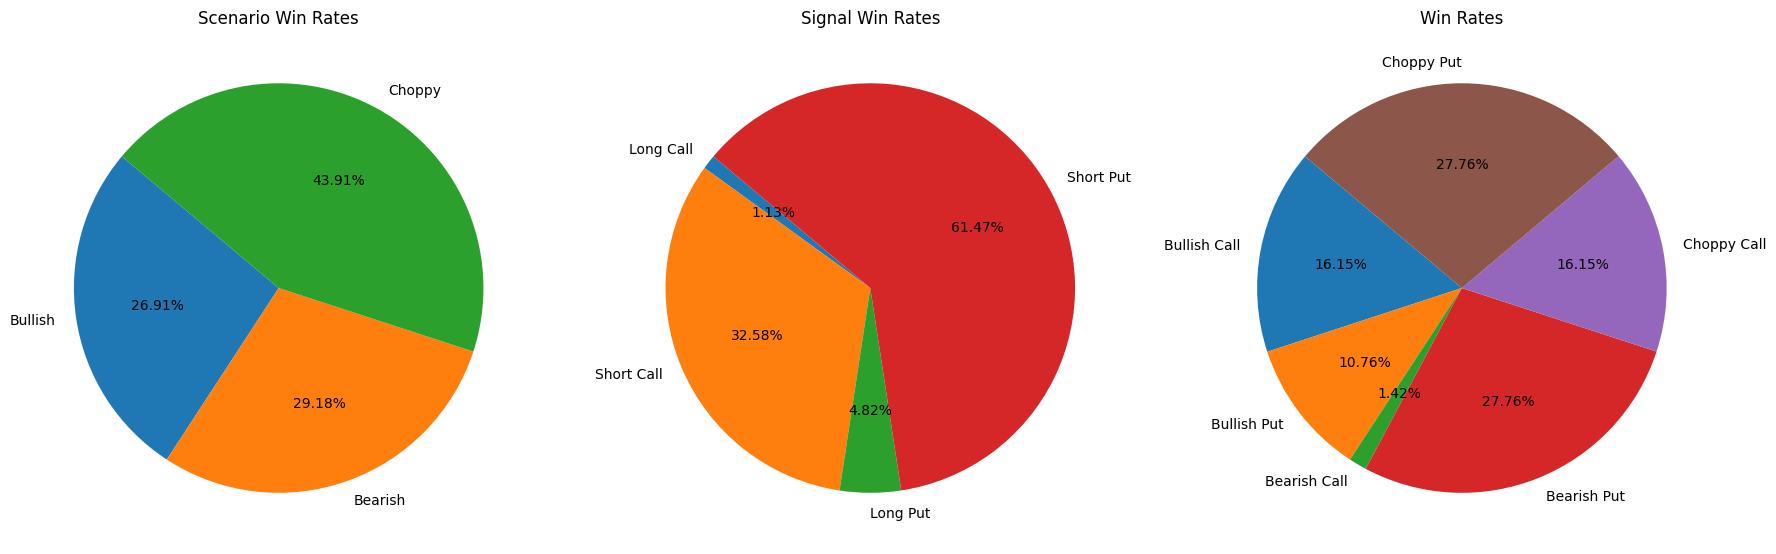

In [ ]:
scenario_win_rates = [lc_win_rate_bullish + sc_win_rate_bullish + lp_win_rate_bullish + sp_win_rate_bullish,
                  lc_win_rate_bearish + sc_win_rate_bearish + lp_win_rate_bearish + sp_win_rate_bearish,
                  lc_win_rate_choppy + sc_win_rate_choppy + lp_win_rate_choppy + sp_win_rate_choppy]

signal_win_rates = [lc_win_rate_bullish + lc_win_rate_bearish + lc_win_rate_choppy,
                    sc_win_rate_bullish + sc_win_rate_bearish + sc_win_rate_choppy,
                    lp_win_rate_bullish + lp_win_rate_bearish + lp_win_rate_choppy,
                    sp_win_rate_bullish + sp_win_rate_bearish + sp_win_rate_choppy]

win_rates = [lc_win_rate_bullish + sc_win_rate_bullish,
             lp_win_rate_bullish + sp_win_rate_bullish,
             lc_win_rate_bearish + sc_win_rate_bearish,
             lp_win_rate_bearish + sp_win_rate_bearish,
             lc_win_rate_choppy + sc_win_rate_choppy,
             lp_win_rate_choppy + sp_win_rate_choppy]

signal_win_rates_labels = ['Long Call', 'Short Call', 'Long Put', 'Short Put']
scenario_win_rates_labels = ['Bullish', 'Bearish', 'Choppy']
win_rates_labels = ['Bullish Call', 'Bullish Put', 'Bearish Call', 'Bearish Put', 'Choppy Call', 'Choppy Put']


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].pie(scenario_win_rates, labels=scenario_win_rates_labels, autopct='%1.2f%%', startangle=140)
axes[0].set_title('Scenario Win Rates')

axes[1].pie(signal_win_rates, labels=signal_win_rates_labels, autopct='%1.2f%%', startangle=140)
axes[1].set_title('Signal Win Rates')

axes[2].pie(win_rates, labels=win_rates_labels, autopct='%1.2f%%', startangle=140)
axes[2].set_title('Win Rates')

plt.tight_layout()
plt.show()

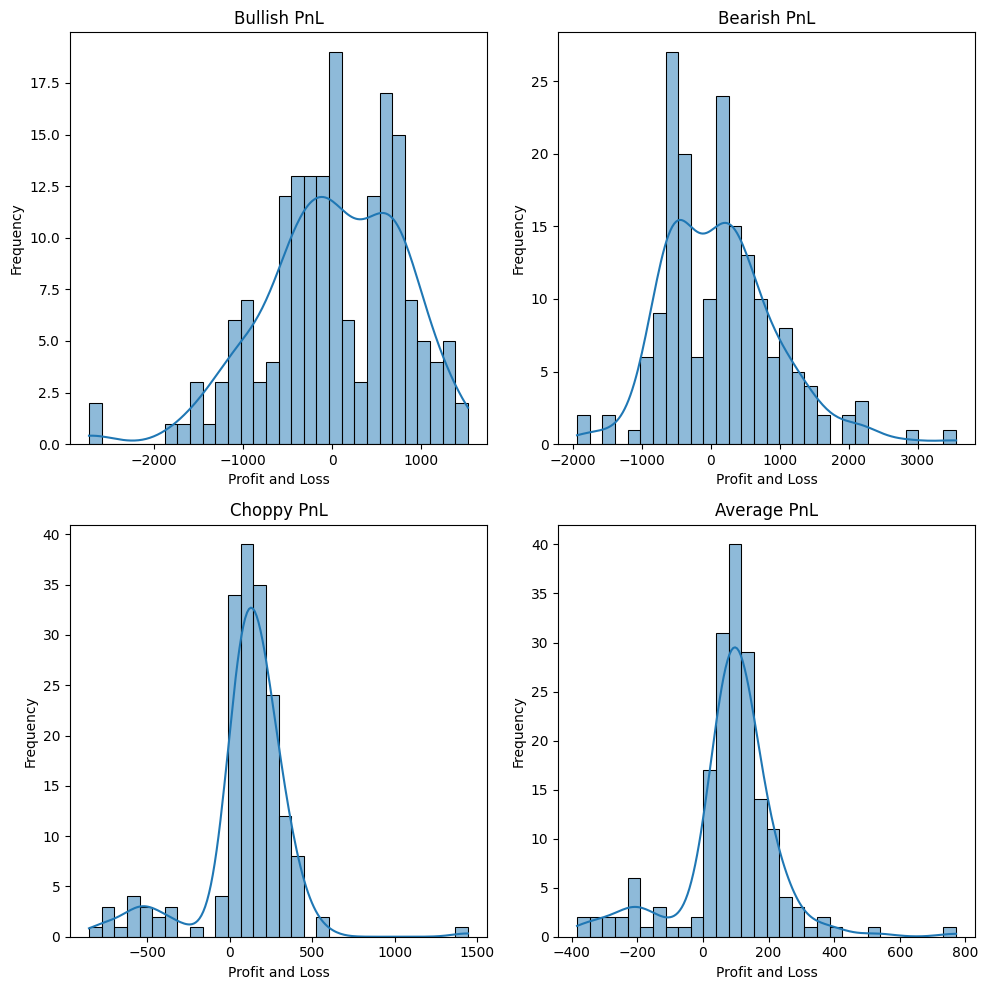

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=analysis, x='bullishPnL', bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Bullish PnL')
axes[0,0].set_xlabel('Profit and Loss')
axes[0,0].set_ylabel('Frequency')

sns.histplot(data=analysis, x='bearishPnL', bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Bearish PnL')
axes[0,1].set_xlabel('Profit and Loss')
axes[0,1].set_ylabel('Frequency')

sns.histplot(data=analysis, x='choppyPnL', bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title('Choppy PnL')
axes[1,0].set_xlabel('Profit and Loss')
axes[1,0].set_ylabel('Frequency')

sns.histplot(data=analysis, x='PnL', bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title('Average PnL')
axes[1,1].set_xlabel('Profit and Loss')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

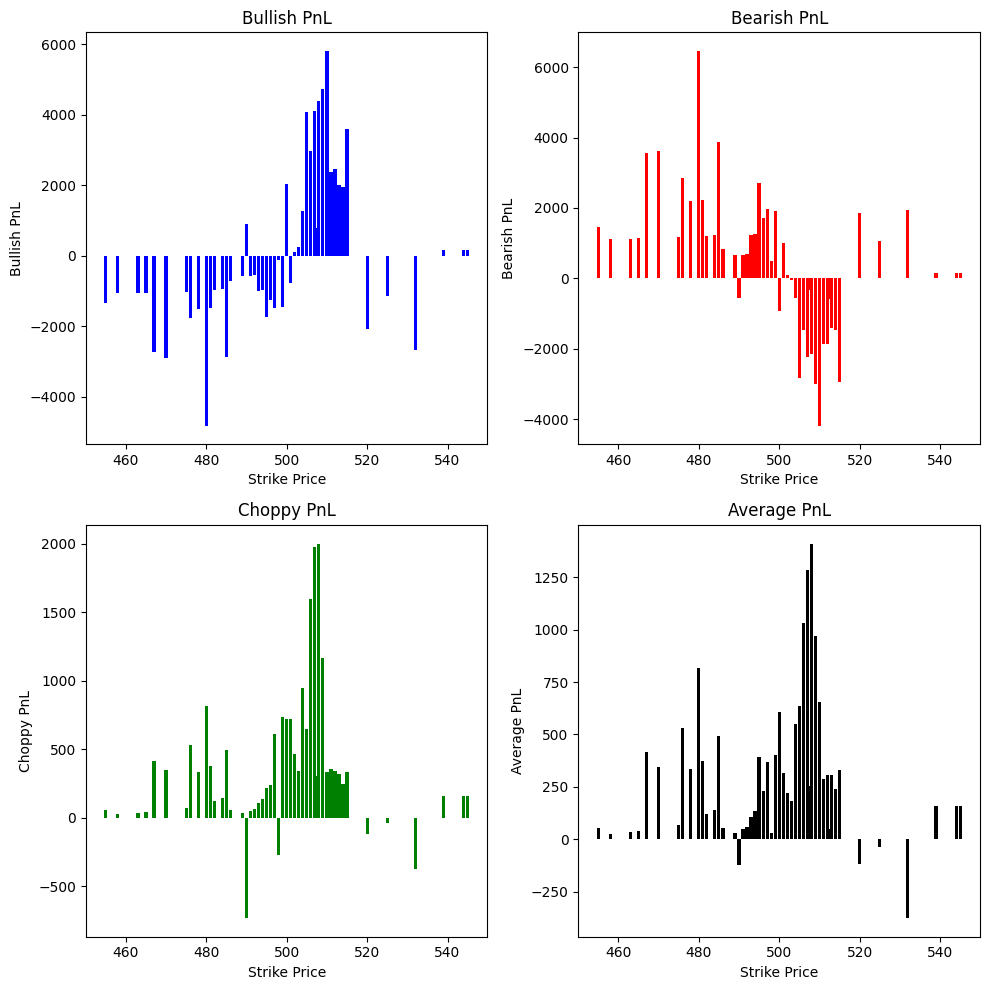

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0,0].bar(analysis.groupby('strike')['bullishPnL'].sum().index, analysis.groupby('strike')['bullishPnL'].sum(), color='b')
axes[0,0].set_xlabel('Strike Price')
axes[0,0].set_ylabel('Bullish PnL')
axes[0,0].set_title('Bullish PnL')

axes[0,1].bar(analysis.groupby('strike')['bearishPnL'].sum().index, analysis.groupby('strike')['bearishPnL'].sum(), color='r')
axes[0,1].set_xlabel('Strike Price')
axes[0,1].set_ylabel('Bearish PnL')
axes[0,1].set_title('Bearish PnL')

axes[1,0].bar(analysis.groupby('strike')['choppyPnL'].sum().index, analysis.groupby('strike')['choppyPnL'].sum(), color='g')
axes[1,0].set_xlabel('Strike Price')
axes[1,0].set_ylabel('Choppy PnL')
axes[1,0].set_title('Choppy PnL')

axes[1,1].bar(analysis.groupby('strike')['PnL'].sum().index, analysis.groupby('strike')['PnL'].sum(), color='black')
axes[1,1].set_xlabel('Strike Price')
axes[1,1].set_ylabel('Average PnL')
axes[1,1].set_title('Average PnL')

plt.tight_layout()
plt.show()

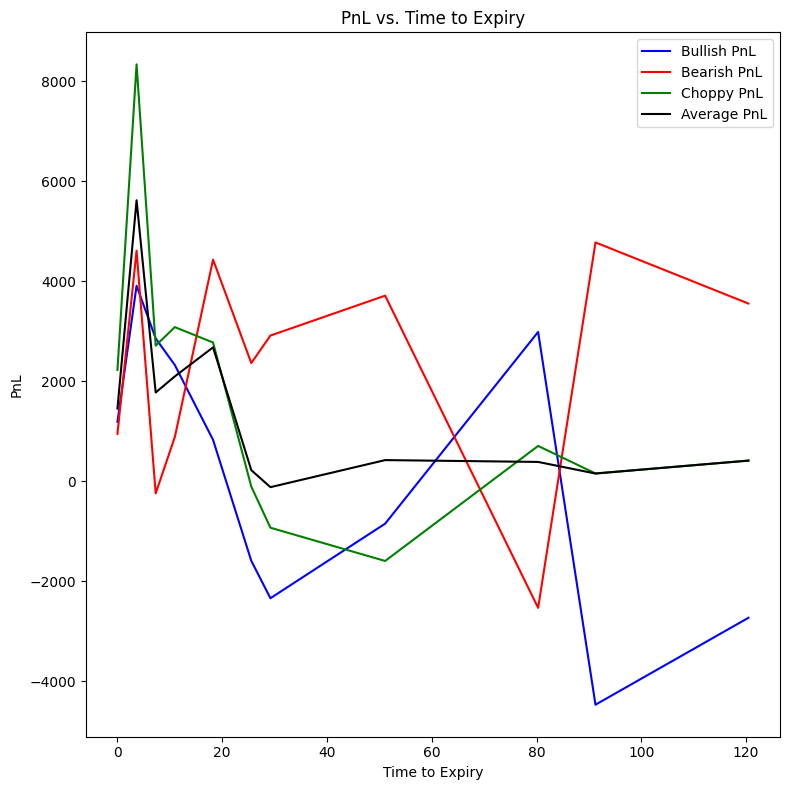

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax.plot(analysis.groupby('T')['bullishPnL'].sum().index * 365, analysis.groupby('T')['bullishPnL'].sum(), color='b', label='Bullish PnL')
ax.plot(analysis.groupby('T')['bearishPnL'].sum().index * 365, analysis.groupby('T')['bearishPnL'].sum(), color='r', label='Bearish PnL')
ax.plot(analysis.groupby('T')['choppyPnL'].sum().index * 365, analysis.groupby('T')['choppyPnL'].sum(), color='g', label='Choppy PnL')
ax.plot(analysis.groupby('T')['PnL'].sum().index * 365, analysis.groupby('T')['PnL'].sum(), color='black', label='Average PnL')

ax.set_xlabel('Time to Expiry')
ax.set_ylabel('PnL')
ax.set_title('PnL vs. Time to Expiry')
ax.legend()

ax.plot(analysis.groupby('impl')['bullishPnL'].sum().index * 365, analysis.groupby('T')['bullishPnL'].sum(), color='b', label='Bullish PnL')
ax.plot(analysis.groupby('T')['bearishPnL'].sum().index * 365, analysis.groupby('T')['bearishPnL'].sum(), color='r', label='Bearish PnL')
ax.plot(analysis.groupby('T')['choppyPnL'].sum().index * 365, analysis.groupby('T')['choppyPnL'].sum(), color='g', label='Choppy PnL')
ax.plot(analysis.groupby('T')['PnL'].sum().index * 365, analysis.groupby('T')['PnL'].sum(), color='black', label='Average PnL')

ax.set_xlabel('Time to Expiry')
ax.set_ylabel('PnL')
ax.set_title('PnL vs. Time to Expiry')
ax.legend()

plt.tight_layout()
plt.show()

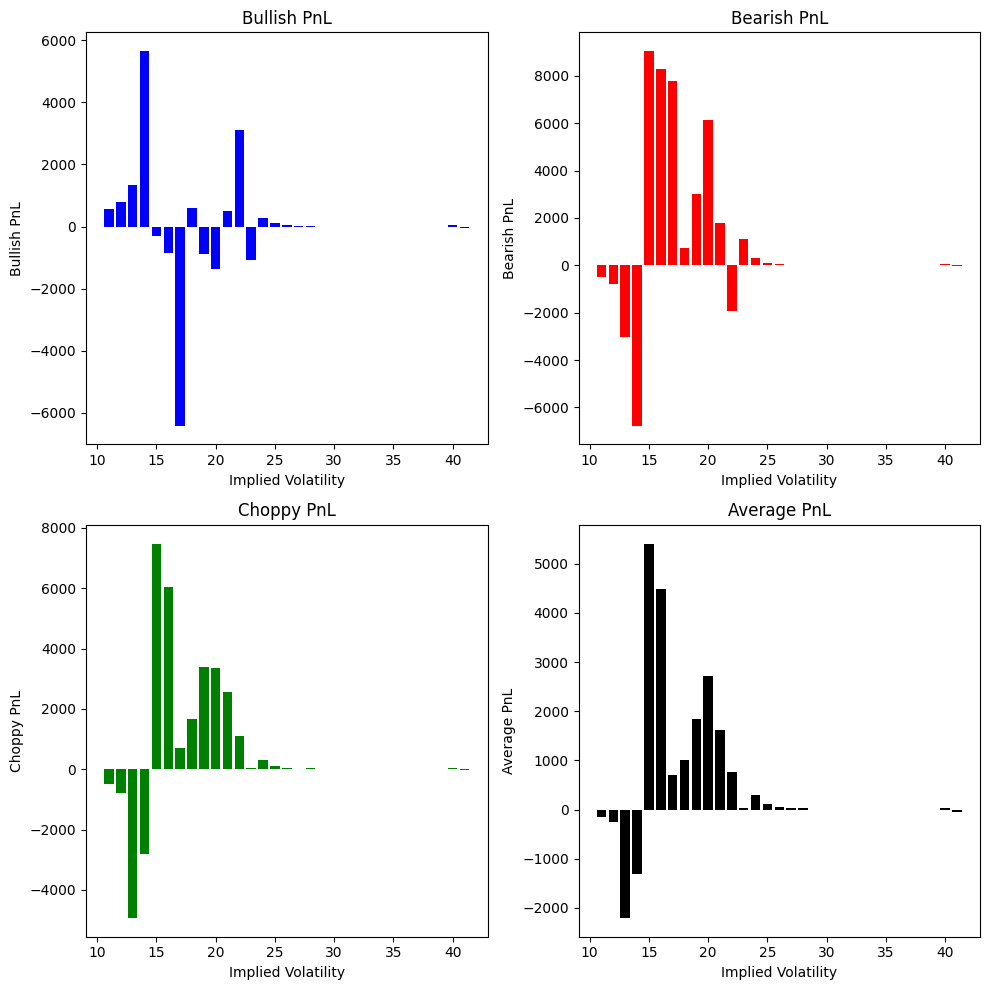

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0,0].bar(analysis.groupby('impliedVolatility')['bullishPnL'].sum().index * 100, analysis.groupby('impliedVolatility')['bullishPnL'].sum(), color='b')
axes[0,0].set_xlabel('Implied Volatility')
axes[0,0].set_ylabel('Bullish PnL')
axes[0,0].set_title('Bullish PnL')

axes[0,1].bar(analysis.groupby('impliedVolatility')['bearishPnL'].sum().index * 100, analysis.groupby('impliedVolatility')['bearishPnL'].sum(), color='r')
axes[0,1].set_xlabel('Implied Volatility')
axes[0,1].set_ylabel('Bearish PnL')
axes[0,1].set_title('Bearish PnL')

axes[1,0].bar(analysis.groupby('impliedVolatility')['choppyPnL'].sum().index * 100, analysis.groupby('impliedVolatility')['choppyPnL'].sum(), color='g')
axes[1,0].set_xlabel('Implied Volatility')
axes[1,0].set_ylabel('Choppy PnL')
axes[1,0].set_title('Choppy PnL')

axes[1,1].bar(analysis.groupby('impliedVolatility')['PnL'].sum().index * 100, analysis.groupby('impliedVolatility')['PnL'].sum(), color='black')
axes[1,1].set_xlabel('Implied Volatility')
axes[1,1].set_ylabel('Average PnL')
axes[1,1].set_title('Average PnL')

plt.tight_layout()
plt.show()